### 전처리

In [353]:
import pandas as pd

# 스코어링 csv 불러오기
scoring_df = pd.read_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/scoring_data/0425/hygiene_review.csv",
    encoding="utf-8",
)
scoring_df = scoring_df.drop_duplicates(subset=["review"])
scoring_df.info()
print(scoring_df["score"].value_counts())

# 감정리뷰 1000개 불러오기
review_df = pd.read_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/review_negative_0425_real.csv",
    encoding="utf-8",
)
review_df = review_df.drop_duplicates(subset=["리뷰"])
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2126 entries, 0 to 2127
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   2126 non-null   int64  
 1   review  2126 non-null   object 
 2   score   465 non-null    float64
 3   reason  2126 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 83.0+ KB
score
0.72    120
0.78     53
0.55     41
0.35     32
0.52     22
0.77     20
0.92     20
0.57     19
0.22     16
0.56     16
0.29     16
0.79     16
0.32     13
0.25      8
0.75      6
0.36      5
0.76      5
0.37      4
0.74      4
0.30      4
0.12      3
0.34      2
0.81      2
0.62      2
0.59      2
0.54      2
0.82      2
0.73      1
0.15      1
0.51      1
0.21      1
0.91      1
0.10      1
0.80      1
0.31      1
0.58      1
0.49      1
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 3594 entries, 0 to 3610
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  


In [354]:
# 데이터 머지
merged_hygiene_df = pd.merge(
    scoring_df,
    review_df,
    left_on="review",  # review_df에서 기준이 되는 컬럼
    right_on="리뷰",  # scoring_df에서 기준이 되는 컬럼
    how="left",  # 공통된 리뷰만 남기고 싶으면 inner, 모두 살리려면 outer
)
merged_hygiene_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   2126 non-null   int64  
 1   review  2126 non-null   object 
 2   score   465 non-null    float64
 3   reason  2126 non-null   object 
 4   가게명     2126 non-null   object 
 5   카테고리    2126 non-null   object 
 6   리뷰      2126 non-null   object 
 7   원본 리뷰   2126 non-null   object 
 8   데이터 구분  2126 non-null   object 
 9   감성      2126 non-null   object 
 10  감성 스코어  2126 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 182.8+ KB


In [ ]:
# 데이터 평균 확인
import numpy as np

average_score = merged_hygiene_df["score"].dropna().mean()
print(average_score)

0.6060430107526882


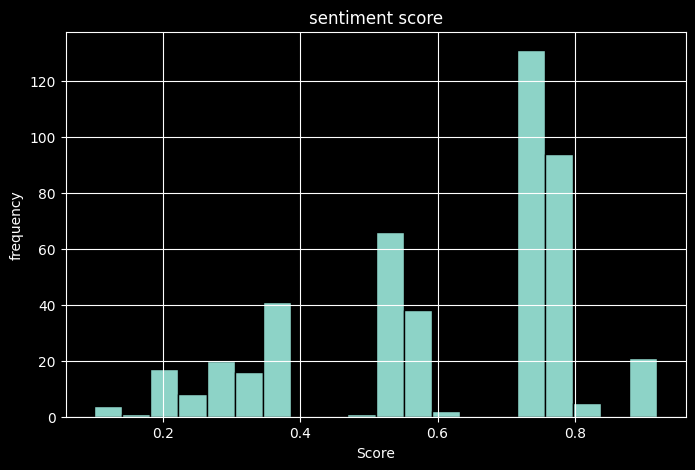

In [356]:
# 부정강도 비율 확인 (개수 고려 X)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(merged_hygiene_df["score"], bins=20, edgecolor="black")
plt.title("sentiment score")
plt.xlabel("Score")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

In [357]:
merged_hygiene_df.head()
merged_hygiene_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   2126 non-null   int64  
 1   review  2126 non-null   object 
 2   score   465 non-null    float64
 3   reason  2126 non-null   object 
 4   가게명     2126 non-null   object 
 5   카테고리    2126 non-null   object 
 6   리뷰      2126 non-null   object 
 7   원본 리뷰   2126 non-null   object 
 8   데이터 구분  2126 non-null   object 
 9   감성      2126 non-null   object 
 10  감성 스코어  2126 non-null   float64
dtypes: float64(2), int64(1), object(8)
memory usage: 182.8+ KB


### 위생 분포 확인

In [ ]:
# 원본 리뷰 별 유효_score 평균 도출
review_score_df = (
    merged_hygiene_df.groupby("원본 리뷰")
    .agg(
        {
            "가게명": "first",  # 각 리뷰가 속한 가게
            "score": lambda x: x.mean(skipna=True) if x.notna().sum() > 0 else pd.NA,
        }
    )
    .reset_index()
    .rename(columns={"score": "유효_score"})
)

review_score_df.to_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/test_data/12345.csv",
    encoding="utf-8-sig",
    index=True,
)

In [ ]:
# 가게별로 유효_score를 그룹화
final_score_df = (
    review_score_df.groupby("가게명")
    .agg(
        리뷰개수=("유효_score", lambda x: x.notna().sum()),  # NaN이 아닌 개수
        최종_score=(
            "유효_score",
            lambda x: x.mean(skipna=True) if x.notna().sum() > 0 else 0,
        ),  # 평균
    )
    .reset_index()
)

# 결과 확인
print(final_score_df.head())
print(final_score_df[final_score_df["리뷰개수"] != 0]["리뷰개수"].mean())
final_score_df.to_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/test_data/final_score.csv",
    encoding="utf-8-sig",
    index=True,
)

        가게명  리뷰개수  최종_score
0    101호술집     0      0.00
1    101호주인     0      0.00
2  153콩나물국밥     1      0.22
3       9공탄     0      0.00
4   A TABLE     0      0.00
1.7135678391959799


In [ ]:
# 부정 리뷰 개수 고려한 부정강도 계산

Q = 8  # 하이퍼파라미터

# 최종 점수 계산
final_score_df["개수반영_score"] = final_score_df["최종_score"] / 2 + (
    1 - np.exp(-final_score_df["리뷰개수"] / Q)
) * (1 - final_score_df["최종_score"] / 2)

hygiene_store_score_mean = final_score_df
hygiene_store_score_mean.head()

,가게명,리뷰개수,최종_score,개수반영_score
0,101호술집,0,0.00,0.000000
1,101호주인,0,0.00,0.000000
2,153콩나물국밥,1,0.22,0.214578
3,9공탄,0,0.00,0.000000
4,A TABLE,0,0.00,0.000000


In [ ]:
# 위생점수 도출
hygiene_store_score_mean["위생점수"] = 1 - hygiene_store_score_mean["개수반영_score"]
hygiene_store_score_mean.head()
hygiene_store_score_mean.to_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/total_data/nonfood_hygiene_세탁.csv",
    encoding="utf-8-sig",
    index=True,
)

/var/folders/zn/8nvw_j512wq3hr0sjmf3vt6m0000gn/T/ipykernel_19211/2105711957.py:21: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/8nvw_j512wq3hr0sjmf3vt6m0000gn/T/ipykernel_19211/2105711957.py:21: UserWarning: Glyph 48624 (\N{HANGUL SYLLABLE BYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/8nvw_j512wq3hr0sjmf3vt6m0000gn/T/ipykernel_19211/2105711957.py:21: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/8nvw_j512wq3hr0sjmf3vt6m0000gn/T/ipykernel_19211/2105711957.py:21: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/8nvw_j512wq3hr0sjmf3vt6m0000gn/T/ipykernel_19211/2105711957.py:21: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/8nvw_j512wq3hr0sjmf3vt6m0000gn/T/ipykerne

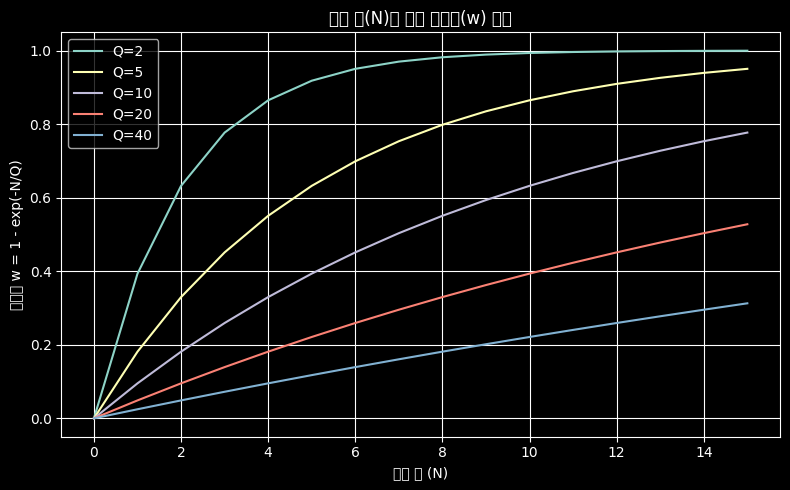

In [362]:
# 적절한 하이퍼 파라메타 추출
import numpy as np
import matplotlib.pyplot as plt

# 리뷰 수 범위 설정 (예: 0 ~ 50개)
N_range = np.arange(0, 16)

# 다양한 Q 값에 대해 가중치 곡선 시각화
Q_values = [2, 5, 10, 20, 40]
plt.figure(figsize=(8, 5))

for Q in Q_values:
    weights = 1 - np.exp(-N_range / Q)
    plt.plot(N_range, weights, label=f"Q={Q}")

plt.title("리뷰 수(N)에 따른 가중치(w) 변화")
plt.xlabel("리뷰 수 (N)")
plt.ylabel("가중치 w = 1 - exp(-N/Q)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

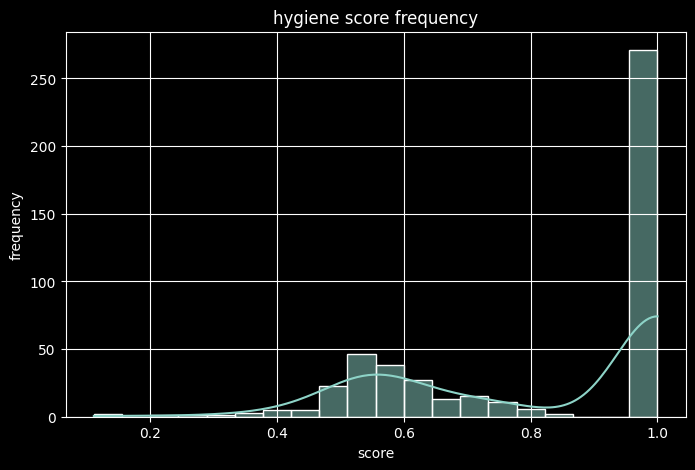

In [365]:
# 위생점수 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(hygiene_store_score_mean["위생점수"], kde=True, bins=20)
plt.title("hygiene score frequency")
plt.xlabel("score")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

/var/folders/zn/8nvw_j512wq3hr0sjmf3vt6m0000gn/T/ipykernel_19211/1334874280.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(hygiene_store_score_mean["위생점수"], fill=True)


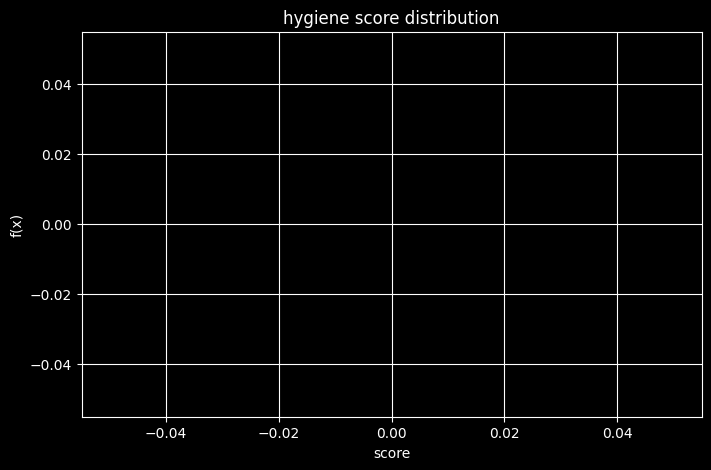

In [337]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(hygiene_store_score_mean["위생점수"], fill=True)
plt.title("hygiene score distribution")
plt.xlabel("score")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

In [222]:
# # Q-Q plot 정규성 검정
# import scipy.stats as stats
# import matplotlib.pyplot as plt

# plt.figure(figsize=(6, 6))
# stats.probplot(service_store_score_mean["서비스점수"], dist="norm", plot=plt)
# plt.title("Q-Q Plot")
# plt.grid(True)
# plt.show()

### 서비스 분포 확인

In [ ]:
import pandas as pd

# 스코어링 csv 불러오기
scoring_df = pd.read_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/scoring_data/0428/비외식업_세탁_서비스점수.csv",
    encoding="utf-8",
)
scoring_df = scoring_df.drop_duplicates(subset=["review"])
scoring_df.info()
print(scoring_df["score"].value_counts())

# 감정리뷰 불러오기
review_df = pd.read_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/비외식업 감정/review_negative_비외식업_세탁.csv",
    encoding="utf-8",
)
review_df = review_df.drop_duplicates(subset=["리뷰"])
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 0 to 8
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  8 non-null      object 
 1   score   2 non-null      float64
 2   reason  8 non-null      object 
dtypes: float64(1), object(2)
memory usage: 256.0+ bytes
score
0.55    1
0.22    1
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 0 to 14
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   가게명     14 non-null     object 
 1   카테고리    14 non-null     object 
 2   리뷰      14 non-null     object 
 3   원본 리뷰   14 non-null     object 
 4   감성      14 non-null     object 
 5   감성 스코어  14 non-null     float64
dtypes: float64(1), object(5)
memory usage: 784.0+ bytes


In [340]:
# 데이터 머지
merged_service_df = pd.merge(
    scoring_df,
    review_df,
    left_on="review",  # review_df에서 기준이 되는 컬럼
    right_on="리뷰",  # scoring_df에서 기준이 되는 컬럼
    how="left",  # 공통된 리뷰만 남기고 싶으면 inner, 모두 살리려면 outer
)
merged_service_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  8 non-null      object 
 1   score   2 non-null      float64
 2   reason  8 non-null      object 
 3   가게명     8 non-null      object 
 4   카테고리    8 non-null      object 
 5   리뷰      8 non-null      object 
 6   원본 리뷰   8 non-null      object 
 7   감성      8 non-null      object 
 8   감성 스코어  8 non-null      float64
dtypes: float64(2), object(7)
memory usage: 708.0+ bytes


In [341]:
average_score = merged_service_df["score"].dropna().mean()
print(average_score)

0.385


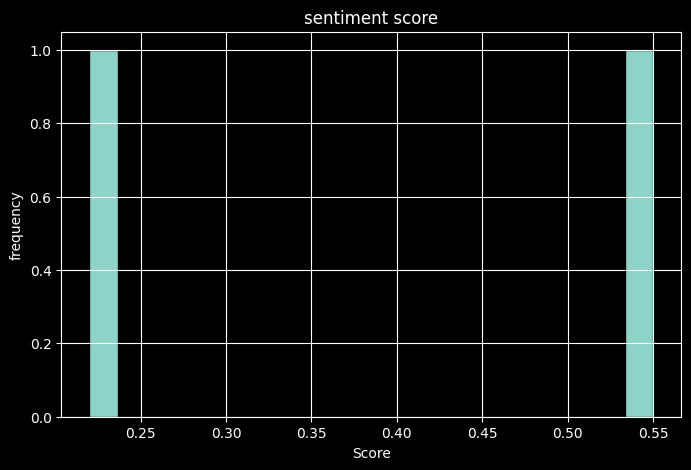

In [342]:
# 부정강도 비율 확인 (개수 고려 X)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(merged_service_df["score"], bins=20, edgecolor="black")
plt.title("sentiment score")
plt.xlabel("Score")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

In [ ]:
# 원본 리뷰 별 유효_score 평균 도출
review_score_service_df = (
    merged_service_df.groupby("원본 리뷰")
    .agg(
        {
            "가게명": "first",  # 각 리뷰가 속한 가게
            "score": lambda x: x.mean(skipna=True) if x.notna().sum() > 0 else pd.NA,
        }
    )
    .reset_index()
    .rename(columns={"score": "유효_score"})
)

review_score_service_df.to_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/test_data/12345_service.csv",
    encoding="utf-8-sig",
    index=True,
)

In [ ]:
# 가게별로 유효_score를 그룹화
final_score_service_df = (
    review_score_service_df.groupby("가게명")
    .agg(
        리뷰개수=("유효_score", lambda x: x.notna().sum()),  # NaN이 아닌 개수
        최종_score=(
            "유효_score",
            lambda x: x.mean(skipna=True) if x.notna().sum() > 0 else 0,
        ),  # 평균
    )
    .reset_index()
)

# 결과 확인
print(final_score_service_df.head())
print(
    final_score_service_df[final_score_service_df["리뷰개수"] != 0]["리뷰개수"].mean()
)
final_score_service_df.to_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/test_data/final_score_service.csv",
    encoding="utf-8-sig",
    index=True,
)

          가게명  리뷰개수  최종_score
0  고품격운동화가방세탁     0      0.00
1      삼성 세탁소     1      0.55
2       엄마손세탁     0      0.00
3     이튼명품세탁소     1      0.22
4        일광세탁     0      0.00
1.0


In [ ]:
# 부정 리뷰 개수 고려한 부정강도 계산

Q = 8  # 하이퍼파라미터

# 최종 점수 계산
final_score_service_df["개수반영_score"] = final_score_service_df["최종_score"] / 2 + (
    1 - np.exp(-final_score_service_df["리뷰개수"] / Q)
) * (1 - final_score_service_df["최종_score"] / 2)

service_store_score_mean = final_score_service_df

In [346]:
# 서비스점수 도출
service_store_score_mean["서비스점수"] = 1 - service_store_score_mean["개수반영_score"]
service_store_score_mean.info()

service_store_score_mean.to_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/total_data/nonfood_service_세탁.csv",
    encoding="utf-8-sig",
    index=True,
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   가게명         5 non-null      object 
 1   리뷰개수        5 non-null      int64  
 2   최종_score    5 non-null      float64
 3   개수반영_score  5 non-null      float64
 4   서비스점수       5 non-null      float64
dtypes: float64(3), int64(1), object(1)
memory usage: 332.0+ bytes


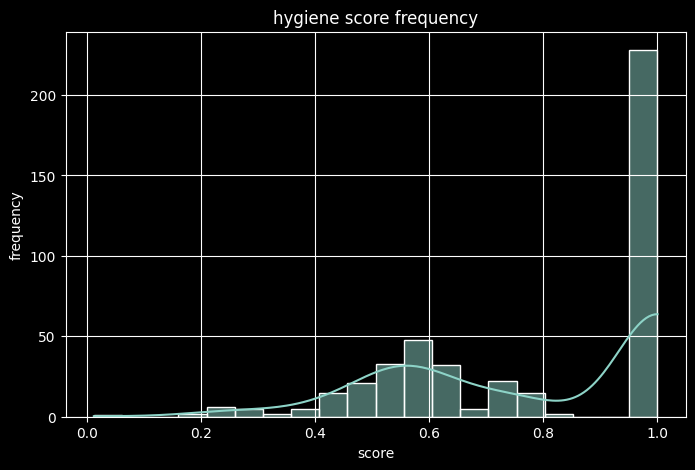

In [257]:
# 서비스점수 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(service_store_score_mean["서비스점수"], kde=True, bins=20)
plt.title("hygiene score frequency")
plt.xlabel("score")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

### 데이터프레임 만들기

In [258]:
hygiene_df = pd.DataFrame(hygiene_store_score_mean)
service_df = pd.DataFrame(service_store_score_mean)

hygiene_df.to_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/total_data/merge_hygiene.csv",
    index=True,
    encoding="utf-8-sig",
)
service_df.to_csv(
    "/Users/seojeonghun/Documents/langchain-kr/20-Projects/review/total_data/merge_service.csv",
    index=True,
    encoding="utf-8-sig",
)